In [2]:
# SET THEANO_FLAGS='gcc.cxxflags="-D_hypot=hypot"'

In [1]:
import warnings
warnings.filterwarnings('ignore', '.*Argument backend_kwargs has not effect in.*')

In [17]:
%env THEANO_FLAGS="gcc.cxxflags='-D_hypot=hypot'"
# this might be required on windows depending on what MINGW version is in your path

import pymc3 as pm
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import datasets 
from matplotlib import pyplot as plt
%matplotlib inline

env: THEANO_FLAGS="gcc.cxxflags='-D_hypot=hypot'"


# Load data

In [13]:
BOSTON = datasets.load_boston()
X, Y = BOSTON['data'], BOSTON['target']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

train_x, test_x, train_y, test_y = train_test_split(X,Y)

scaler_x = RobustScaler()
train_x = scaler_x.fit_transform(train_x)
test_x = scaler_x.transform(test_x)

scaler_y = RobustScaler()
train_y = scaler_y.fit_transform(train_y.reshape(-1, 1)).reshape(-1)
test_y = scaler_y.transform(test_y.reshape(-1, 1)).reshape(-1)

# Create and evaluate a normal multidimensional linear regression  

$$y = Ax + b$$

In [20]:

#reg = SVR()
reg = LinearRegression()
reg.fit(train_x, train_y)

reg.score(train_x, train_y), reg.score(test_x, test_y)

(0.73948792604813, 0.7275530658199487)

In [30]:
reg.coef_, reg.intercept_

(array([-0.03923114,  0.12324659,  0.04880985,  0.47834104, -0.40401285,
         0.32312487,  0.03957348, -0.50053744,  0.67445073, -0.52518155,
        -0.34622699,  0.02446524, -0.57982154]),
 0.16089031344628116)

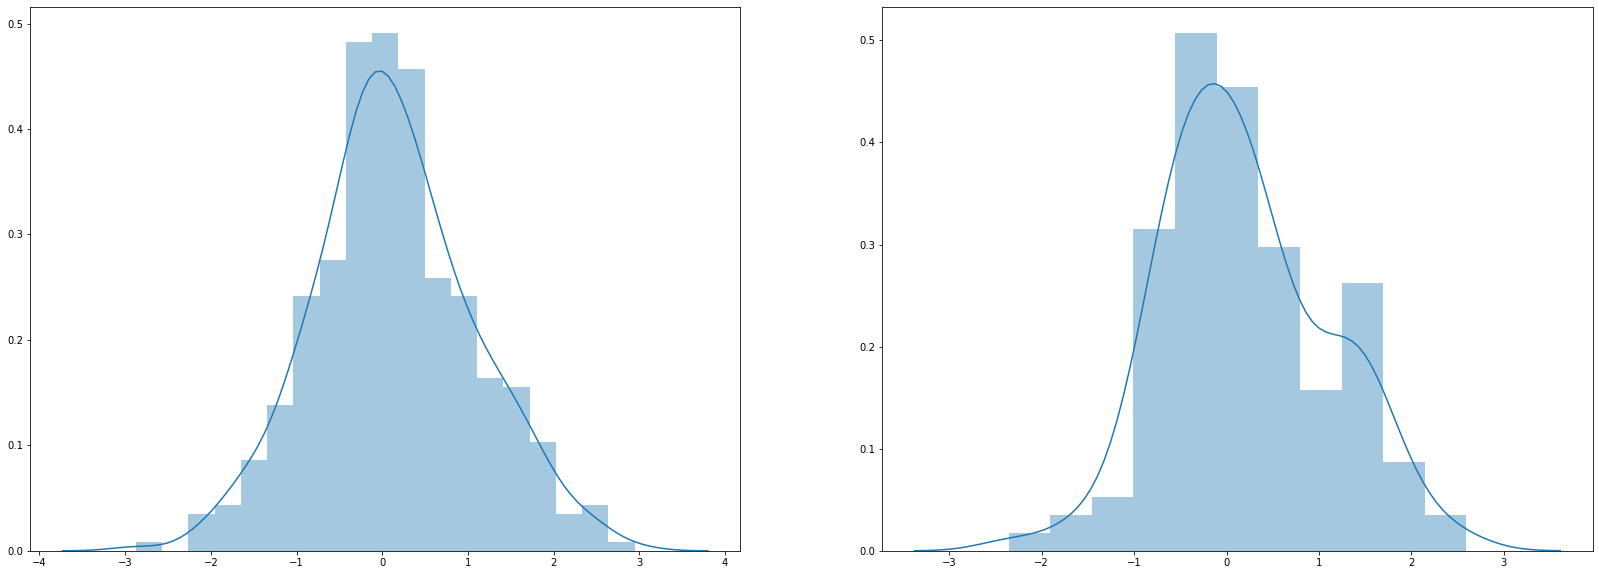

In [21]:

preds_train = reg.predict(train_x)
preds_test = reg.predict(test_x)

fig, axes = plt.subplots(1, 2, figsize=(14*2, 10))
sns.distplot(preds_train, ax=axes[0])
sns.distplot(preds_test, ax=axes[1])

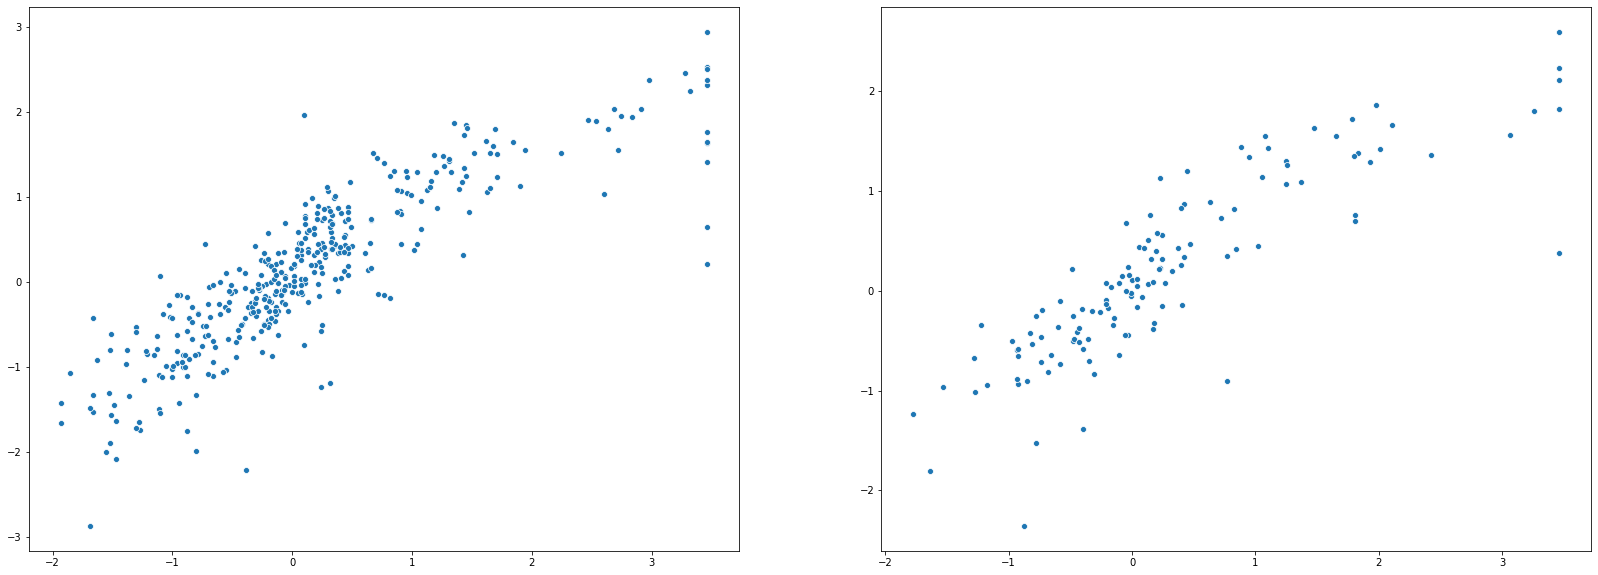

In [22]:
_, axes2 = plt.subplots(1, 2, figsize=(14*2, 10))
sns.scatterplot(train_y, preds_train, ax=axes2[0])
sns.scatterplot(test_y, preds_test, ax=axes2[1])

# Create a Probabilistic Model

$$y_{lik} = \mathscr{N}\left(\mathscr{N}\left(\mu_1, \sigma_1\right) X + \mathscr{N}\left(\mu_2, \sigma_2\right), \left|\mathscr{N}\left(0, 1\right)\right|\right) $$

In [31]:
def model_factory(X, Y):
    with pm.Model() as model:

        # Priors 
        beta = pm.Normal('beta', mu=0, sd=1, shape=(13, 1))
        intercept = pm.Normal('intercept', mu=0, sd=0.5)

        std = pm.HalfNormal('std', sd=1)

        # Likelihood
        price = intercept + pm.math.dot(X, beta)

        y_lik = pm.Normal('y_lik', mu=price, sd=std, observed = Y)
 
    return model

In [32]:
with model_factory(train_x, train_y) as model:
    trace = pm.sample(draws=500, tune=500, cores=8)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '14028' (I am process '5192')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [std, intercept, beta]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 2409 seconds.
The acceptance probability does not match the target. It is 0.9066239867231772, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954338746567017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8976732159044957, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892104751608428, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8933749660295819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9814293727227187, but should be close to 0.8. Try to increase the number of t

#### Does this warning matter?


`The acceptance probability does not match the target. It is 0.9066239867231772, but should be close to 0.8. Try to increase the number of tuning steps.`

Discussion: https://discourse.pymc.io/t/warning-when-nuts-probability-is-greater-than-acceptance-level/594/4

In [33]:
import pickle
import os

if not os.path.exists('models/'):
    os.makedirs('models/')

with open('models/first_model.pkl', 'wb') as modelbin:
    pickle.dump(model, modelbin)
        
with open('models/first_trace.pkl', 'wb') as tracebin:
    pickle.dump(trace, tracebin)

In [28]:
model_factory(train_x, train_y)

# Plotting https://docs.pymc.io/api/plots.html

## Work in Progress

* I'm getting around to making sense of these properly

* So far my understanding is that these can now be used to test the sensibility of our assumption about the model

Our model was $y_{likelihood} = \beta X + \text{intercept}$ which corresponds to the $y = Ax + b$ linear regression model


c:\users\pekka\envs\pymc3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002621C97A400>,
      dtype=object)

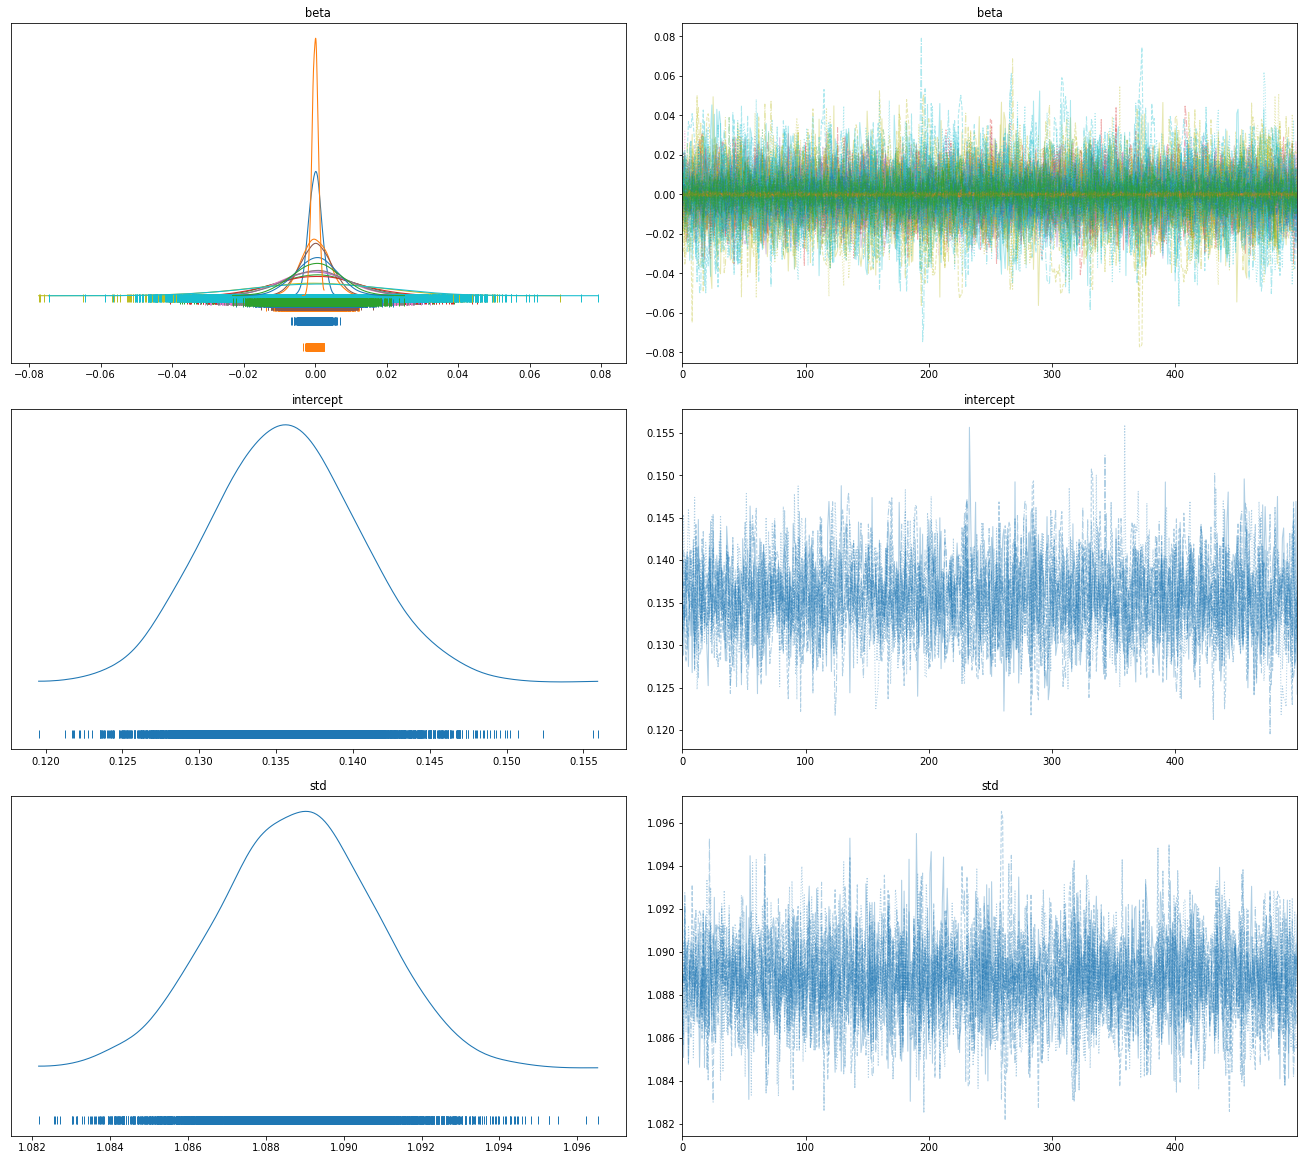

In [34]:
pm.plots.traceplot(trace, compact=True, combined=True, figsize=(18, 8*2), rug=True)

c:\users\pekka\envs\pymc3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002621F63B9E8>,
      dtype=object)

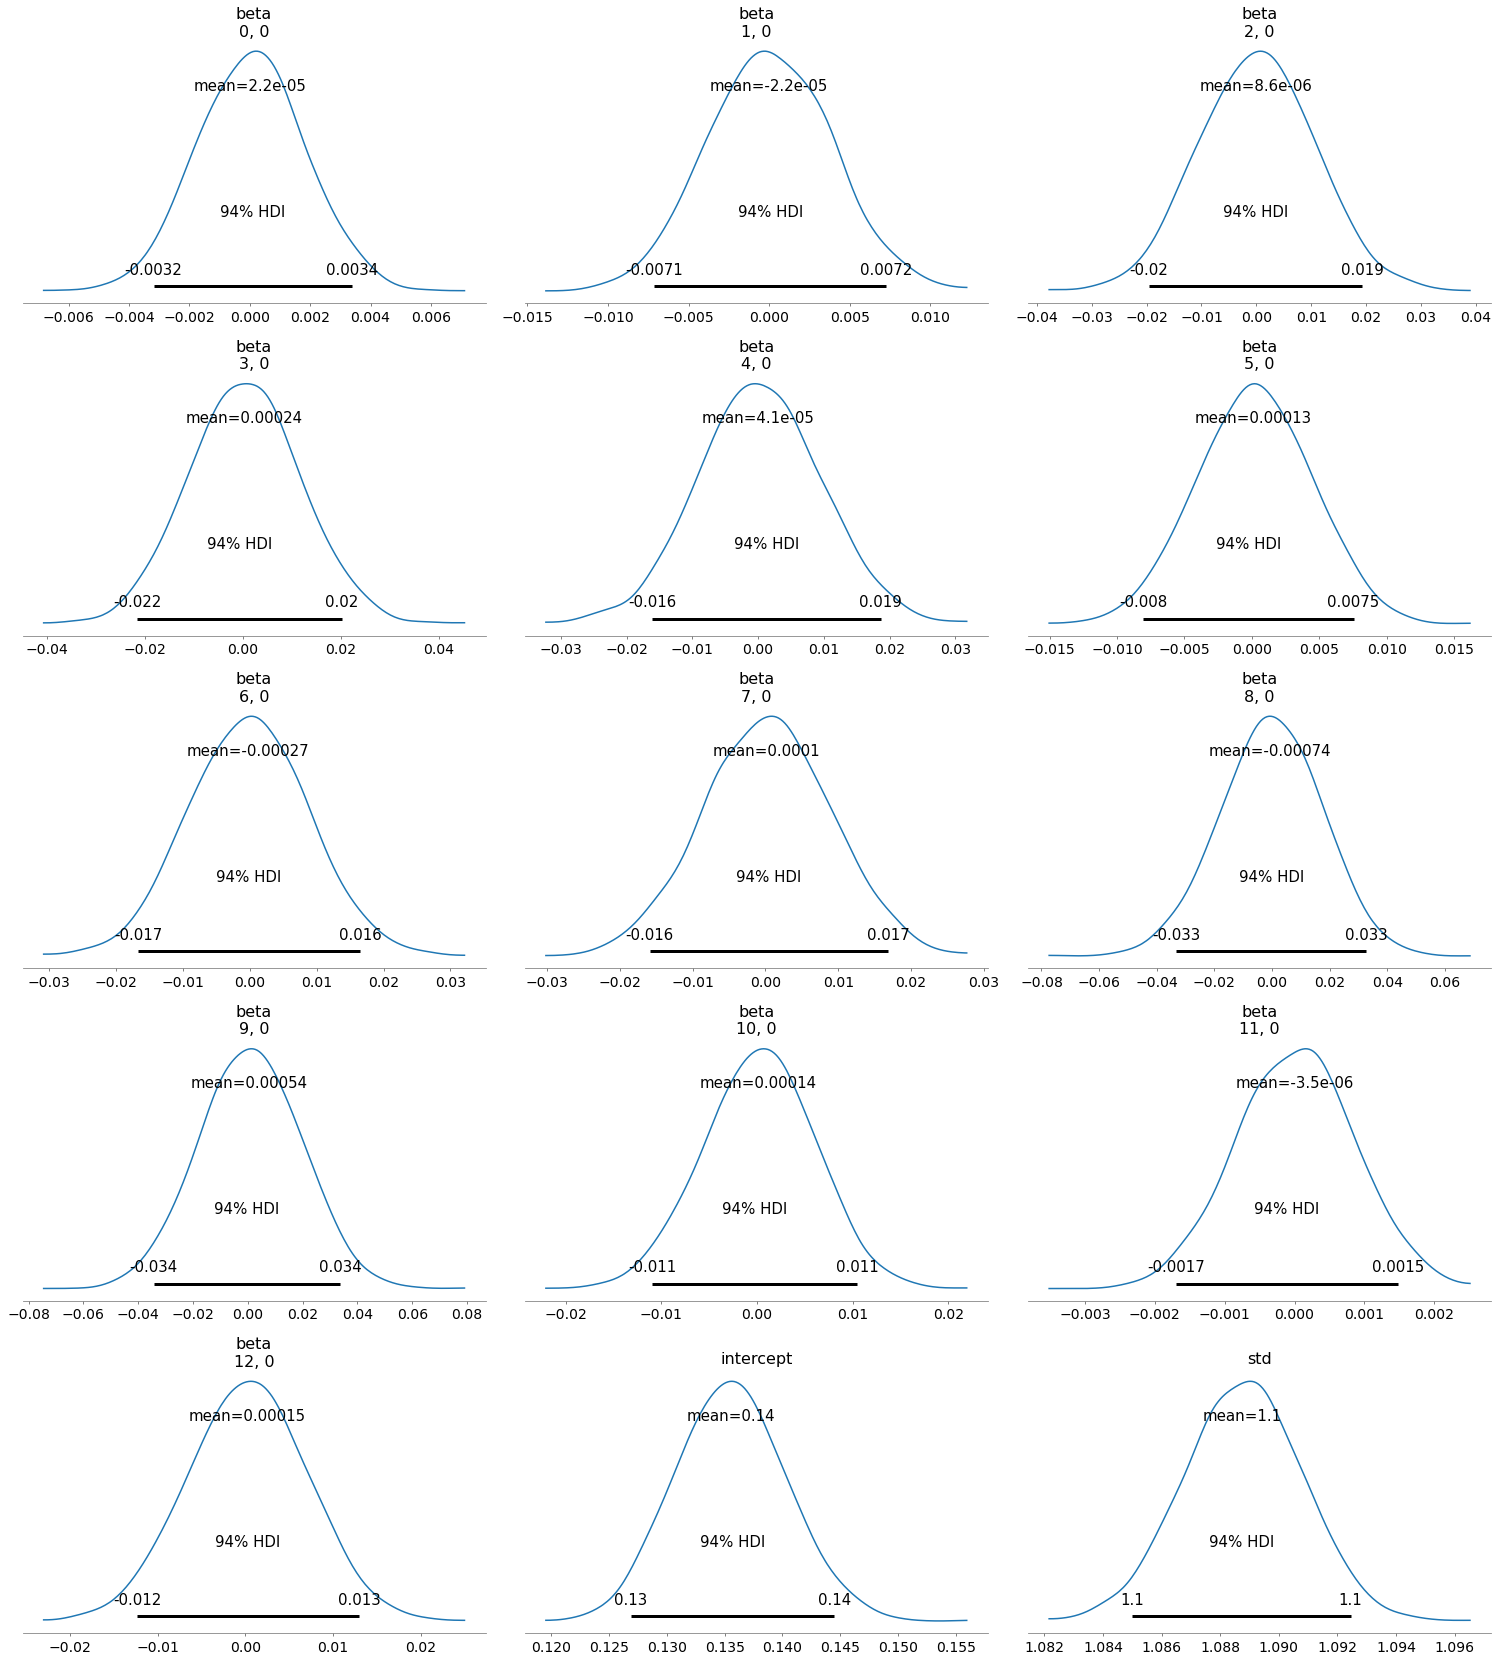

In [35]:
pm.plot_posterior(trace, point_estimate='mean')

c:\users\pekka\envs\pymc3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002622096F828>],
      dtype=object)

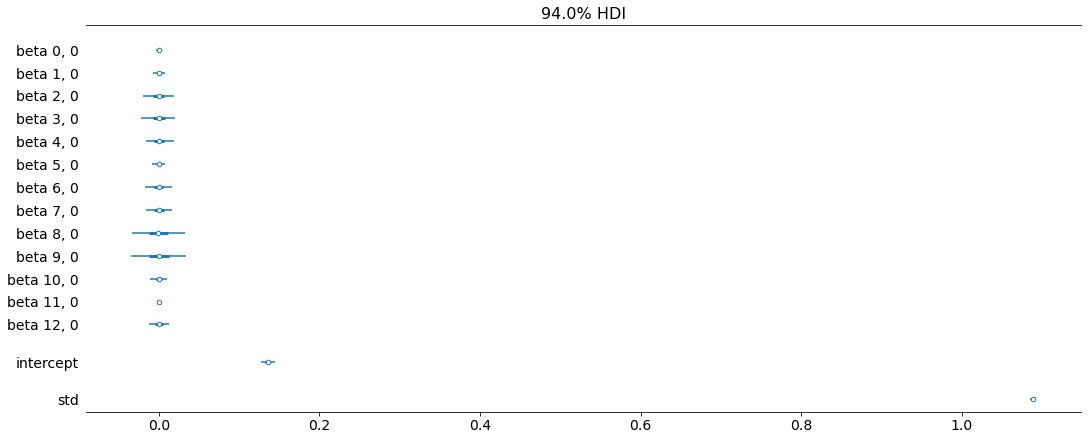

In [36]:
pm.plots.forestplot(trace, combined=True, figsize=(15, 6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002621CE125C0>],
      dtype=object)

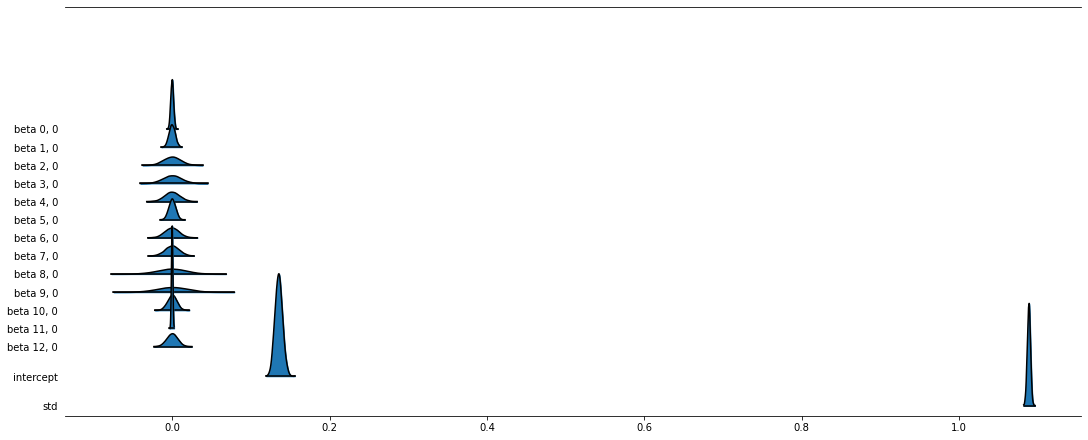

In [37]:
pm.plots.forestplot(trace, kind='ridgeplot', combined=True, figsize=(15, 6))